In [ ]:
## 시각화 (6개 변수 결과)

# X, hidden_states 길이에 맞는 인덱스만 시각화
valid_idx = df[variables_new].dropna().index
dates_valid = df.loc[valid_idx, 'date']
sp500_valid = df.loc[valid_idx, 'S&P500']

plt.figure(figsize=(18, 8))
plt.plot(dates_valid, sp500_valid, color='gray', alpha=0.7, label='S&P500 Index')

# 상태별로 점 컬러 다르게 찍기
state_colors = ['blue', 'orange', 'green', 'red']
    
for state in range(n_states):
    idx = hidden_states_new == state
    plt.scatter(dates_valid[idx], sp500_valid.values[idx], s=20, color=state_colors[state], label=f'State {state}')

plt.title("6개 변수 HMM 분류 결과: S&P500 지수 추이 + 국면(상태) 구분")
plt.xlabel("Date")
plt.ylabel("S&P500 Index")
plt.legend()
plt.tight_layout()

# xlabel 옵션
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

In [ ]:
## 상태별 해석 가능성 설명 (6개 변수)

# 상태별 평균 값 확인
state_means_new = pd.DataFrame(model_new.means_, columns = variables_new)
state_means_new.index.name = 'State'

# 상태별 특징 요약
print("상태별 변수 평균 (6개 변수):\n", state_means_new.round(3))

# 경제 해석 예시
print("\n6개 변수 기반 상태별 특성:")
for state in range(n_states):
    print(f"\n[상태 {state}]")
    for col in variables_new:
        direction = "↑" if state_means_new.loc[state, col] > 0 else "↓"
        print(f"{col}: {direction} ({state_means_new.loc[state, col]:.3f})")
        
# 상태별 빈도
state_counts_new = pd.Series(hidden_states_new).value_counts().sort_index()
print(f"\n상태별 빈도:")
for state, count in state_counts_new.items():
    percentage = count / len(hidden_states_new) * 100
    print(f"State {state}: {count}개월 ({percentage:.1f}%)")

In [ ]:
## HMM 모델링 및 상태 분류 (6개 변수)
from hmmlearn.hmm import GaussianHMM

# 상태 개수 지정 (4개 국면)
n_states = 4

# HMM 모델 학습
model_new = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model_new.fit(df_scaled_new)

# 상태 추정
hidden_states_new = model_new.predict(df_scaled_new)
df['state_new'] = hidden_states_new

# 2. 상태별(국면별) 변수 특성(평균, 표준편차 등) 확인
print("6개 변수 HMM 결과:")
for i in range(n_states):
    print(f"\nState {i}: 빈도 = {(hidden_states_new==i).sum()}")
    for j, col in enumerate(variables_new):
        mean = df.loc[hidden_states_new==i, col].mean()
        std = df.loc[hidden_states_new==i, col].std()
        print(f"  {col}: 평균={mean:.4f}, 표준편차={std:.4f}")

# 전이확률 행렬 및 상태별 통계
print("\n전이확률행렬:")
print(pd.DataFrame(model_new.transmat_.round(3)))
print("\n상태별 평균 (표준화된 값):")
print(pd.DataFrame(model_new.means_.round(3), columns=variables_new))

In [ ]:
## 개선된 변수로 scaling
scaler_new = StandardScaler()

# 6개 변수 조합으로 스케일링
df_scaled_new = scaler_new.fit_transform(df[variables_new])

print(f"스케일링 완료: {df_scaled_new.shape}")
print(f"변수 순서: {variables_new}")

In [ ]:
## 기초통계 (6개 변수)
for col in variables_new:
    print(f"{col} - 평균: {df[col].mean():.4f}, 표준편차: {df[col].std():.4f}, min: {df[col].min()}, max: {df[col].max()}")

# 상관계수(피어슨) 계산
corr_matrix_new = df[variables_new].corr()  # 기본은 Pearson 상관계수
print("\n상관계수 매트릭스:")
print(corr_matrix_new.round(3))

In [ ]:
# 6개 변수로 개선된 HMM 분석
# 기존 코드 구조 유지하면서 변수만 변경

# 개선된 변수 조합 적용 (6개 변수)
variables_new = ['VIX_SPX', 'UST10Y', 'DXY', 'MOVE', 'GoldSpot', 'MarginDebt']
print(f"새로운 변수 조합: {variables_new}")

# 별도 변수값으로 사용
sp500 = df['S&P500'].values
dates = df['date'].values

### 4개국면 구분을 위한 은닉마르코프 모델
1. 데이터 기간
- 1998.08 ~ 2025.04 (월 기준) 

2. 사용 변수

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

## 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')


In [ ]:
## Load Data
file_path = 'C:/Users/wnghk/Desktop/ACADEMY/2025-1.5/계량경제/'
df = pd.read_excel(file_path+'Monthly_data_v1.0.xlsx')
df.head()

In [ ]:
df_cols = [col for col in df.columns if col != 'date']
df_cols

['S&P500',
 'S&P500_rate',
 'UST10Y',
 'VIX_SPX',
 'TermSpread',
 'CreditSpread',
 'DXY',
 'MarginDebt',
 'MOVE',
 'UnempRate',
 'ExpInfl10Y',
 'CS_HPI',
 'GoldSpot']

In [ ]:
# 상관계수(피어슨) 계산
corr_matrix = df[df_cols].corr()  # 기본은 Pearson 상관계수
print(corr_matrix)

                S&P500  S&P500_rate    UST10Y   VIX_SPX  TermSpread  \
S&P500        1.000000     0.090821  0.081847  0.029290   -0.013998   
S&P500_rate   0.090821     1.000000  0.156717 -0.693923   -0.054082   
UST10Y        0.081847     0.156717  1.000000 -0.116937    0.391337   
VIX_SPX       0.029290    -0.693923 -0.116937  1.000000    0.056985   
TermSpread   -0.013998    -0.054082  0.391337  0.056985    1.000000   
CreditSpread -0.022406    -0.493282 -0.502624  0.383513    0.012671   
DXY           0.026270    -0.325845  0.225975  0.217854   -0.054471   
MarginDebt    0.025165     0.534476  0.237150 -0.274213    0.047192   
MOVE          0.018282    -0.357719  0.110161  0.486872    0.218596   
UnempRate    -0.037516     0.075208 -0.033224 -0.083017    0.014937   
ExpInfl10Y   -0.007911     0.288258  0.476945 -0.174270    0.233643   
CS_HPI        0.156993     0.070297  0.087942 -0.029497   -0.097547   
GoldSpot      0.033105     0.050799 -0.273214 -0.027844   -0.063986   

     

-----
#### 1. 기초데이터 분석
##### 1) 데이터 전처리

In [ ]:
## 데이터 확인
print("1. row, col : ", df.shape)    # (321, 13)

## 결측치/이상치 확인 및 처리
df_cols = [col for col in df.columns]
print("2. 변수별 결측치\n", df[df_cols].isnull().sum())

# 날짜 컬럼 변환
df['date'] = pd.to_datetime(df['date'], format='%Y%m')

1. row, col :  (321, 14)
2. 변수별 결측치
 date            0
S&P500          0
S&P500_rate     0
UST10Y          0
VIX_SPX         0
TermSpread      0
CreditSpread    0
DXY             0
MarginDebt      0
MOVE            0
UnempRate       0
ExpInfl10Y      0
CS_HPI          0
GoldSpot        0
dtype: int64


In [ ]:
## 더미화

## 기대인플레이션 단순 2% 기준
# df['ExpInfl10Y_dummy'] = (df['ExpInfl10Y'] >= 0.2).astype(int)

## 소비자
# 조건: (직전월 < 5%) & (당월 >= 5%)인 달만 1, 아니면 0
# 1. 직전월 시리즈 생성 (shift)
prev = df['UnempRate'].shift(1)

# 2. 조건 결합
df['UnempRate_5over_entry'] = ((prev < 5) & (df['UnempRate'] >= 5)).astype(int)

## 2% 이상 인플레이션
# 이하 인플레이션 x

In [ ]:
# 개선된 변수 조합 적용
variables = ['S&P500_rate', 'VIX_SPX', 'UST10Y', 'UnempRate', 'CreditSpread', 'MOVE']
print(f"개선된 변수 조합: {variables}")

# 별도 변수값으로 사용
sp500 = df['S&P500'].values
dates = df['date'].values

In [ ]:
## 기초통계
for col in variables:
    print(f"{col} - 평균: {df[col].mean():.4f}, 표준편차: {df[col].std():.4f}, min: {df[col].min()}, max: {df[col].max()}")

# 상관계수(피어슨) 계산
corr_matrix = df[variables].corr()  # 기본은 Pearson 상관계수
print(corr_matrix)

S&P500_rate - 평균: 0.0060, 표준편차: 0.0448, min: -0.16942453444905514, max: 0.12684410293315374
UST10Y - 평균: -0.0041, 표준편차: 0.2638, min: -1.0396, max: 0.8729999999999998
VIX_SPX - 평균: 0.0234, 표준편차: 0.2324, min: -0.4589689637033141, max: 1.3457095709570956
CreditSpread - 평균: 0.0539, 표준편차: 23.1643, min: -82.07, max: 156.04000000000002
MarginDebt - 평균: 0.0062, 표준편차: 0.0449, min: -0.197188679518142, max: 0.12377804889348765
MOVE - 평균: 0.0157, 표준편차: 0.1759, min: -0.36103493501848094, max: 1.0242718446601944
UnempRate - 평균: -0.0009, 표준편차: 0.6352, min: -2.1999999999999993, max: 10.4
CS_HPI - 평균: 0.0041, 표준편차: 0.0079, min: -0.022553982187479837, max: 0.0271653954654687
GoldSpot - 평균: 0.0087, 표준편차: 0.0467, min: -0.16889603306734025, max: 0.16845275344180233
ExpInfl10Y_dummy - 평균: 0.0966, 표준편차: 0.2958, min: 0, max: 1
                  S&P500_rate    UST10Y   VIX_SPX  CreditSpread  MarginDebt  \
S&P500_rate          1.000000  0.156717 -0.693923     -0.493282    0.534476   
UST10Y               0.1567

In [ ]:
## Feature selection

from sklearn.linear_model import LassoCV
X = df[variables]
y = df['S&P500_rate']
lasso = LassoCV(cv=5).fit(X, y)
importance = pd.Series(lasso.coef_, index=variables)
print(importance.sort_values(ascending=False))


# from statsmodels.tsa.stattools import grangercausalitytests
# variables = [col for col in df.columns if col not in ['date', 'S&P500']]
# for var in variables:
#     print(f'--- {var} ---')
#     grangercausalitytests(df[['S&P500', var]].dropna(), maxlag=3, verbose=True)

S&P500_rate     0.507106
UST10Y         -0.000000
MarginDebt      0.000000
UnempRate       0.000000
MOVE           -0.000000
CS_HPI          0.000000
GoldSpot        0.000000
CreditSpread   -0.000296
VIX_SPX        -0.045168
dtype: float64


In [ ]:
# ## 필요시 ----------------------------------------------------------

# # 결측치 처리 → 결측치가 있으면 보간/제거. 일반적으로 선형보간 사용
# df[variables] = df[variables].interpolate(method='linear')
# df = df.dropna(subset=variables).reset_index(drop=True)


# # 로그 변환 : 성장률 분석에 적합, 분포 안정화

# rate_cols = ['GoldSpot']

# for col in df.columns:
#     if col in rate_cols :
#         # 등락률(변화율) 계산
#         df[f'rate_{col}'] = df[col].pct_change() * 100     # 퍼센트 단위
    
# # 로그 변환
# df[f'log_{col}'] = np.log(df[col])

# df = df.dropna().reset_index(drop=True)  # 시작값은 null로 제거
# df

# # 차분 : 비정상성 제거, 수준에서 성장률로 변환
# # diff_data = df.diff().dropna()
# # diff_data

,date,UST10Y,VIX_SPX,TermSpread,CreditSpread,DXY,MOVE,UnempRate,ExpInfl10Y,CS_HPI,GoldSpot,log_GoldSpot,rate_GoldSpot
0,2025-03-01,4.211,22.28,31.799,179.09,104.210,101.35,4.2,2.3703,327.60,3123.57,8.046732,-5.021422
1,2025-02-01,4.212,19.63,21.523,160.18,107.614,104.46,4.1,2.3677,325.09,2857.83,7.957818,-8.507573
2,2025-01-01,4.543,16.43,33.749,143.13,108.370,91.76,4.0,2.4302,323.65,2798.41,7.936807,-2.079200
3,2024-12-01,4.575,17.35,32.529,141.10,108.487,98.80,4.1,2.3388,323.36,2624.50,7.872646,-6.214600
4,2024-11-01,4.178,13.51,1.347,156.15,105.737,95.22,4.2,2.2679,323.77,2643.15,7.879727,0.710612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1998-12-01,4.650,24.42,9.400,258.20,94.170,121.13,4.4,0.8019,92.45,288.25,5.663828,0.733881
316,1998-11-01,4.710,26.01,27.500,247.60,96.200,87.22,4.4,0.9815,92.20,293.20,5.680855,1.717259
317,1998-10-01,4.595,28.05,32.800,268.50,93.680,121.06,4.5,0.9827,92.00,292.55,5.678636,-0.221692
318,1998-09-01,4.395,40.95,27.050,259.00,96.170,124.22,4.6,0.8509,91.76,296.95,5.693564,1.504016


-------
#### 2. 모델링 : 은닉 마르코프 체인
- Multinomial HMM : input이 discrete
- GaussianHMM : input이 continuous
- GMMHMM : 여러개의 gaussian 모델로 확장된 모델

-----
##### 2) GaussianHMM

In [ ]:
## 데이터 복제
df2 = df.copy()
variables

['S&P500_rate',
 'UST10Y',
 'VIX_SPX',
 'CreditSpread',
 'MarginDebt',
 'MOVE',
 'UnempRate',
 'ExpInfl10Y',
 'CS_HPI',
 'GoldSpot']

In [ ]:
# 개선된 변수 조합에 맞는 전처리
# %p형 변수 리스트 (포인트 단위)
pp_vars = ['S&P500_rate', 'UST10Y', 'UnempRate', 'CreditSpread']

# % 변화율형 변수 리스트 (이미 변화율)
pct_vars = ['VIX_SPX', 'MOVE']

# %p형 변수를 변화율(%)로 변환: (이번달-전달)/전달*100
for col in pp_vars:
    df2[f'{col}_chg_pct'] = df2[col].pct_change() * 100
    
all_vars = [f'{col}_chg_pct' for col in pp_vars] + pct_vars
df2[all_vars] = df2[all_vars].replace([np.inf, -np.inf], np.nan)

# NaN 또는 inf 포함된 행 전체를 drop
df2 = df2.dropna(subset=all_vars).reset_index(drop=True)

print(f"전처리된 변수들: {all_vars}")
print(f"사용 가능한 데이터 수: {len(df2)}개월")

In [ ]:
## 개선된 변수로 scaling
scaler = StandardScaler()

# 개선된 변수 조합으로 스케일링
df_scaled = scaler.fit_transform(df2[all_vars])

print(f"스케일링 완료: {df_scaled.shape}")
print(f"변수 순서: {all_vars}")

In [ ]:
## HMM 모델링 및 상태 분류
from hmmlearn.hmm import GaussianHMM

# 상태 개수 지정 (4개 국면)
n_states = 4

# HMM 모델 학습
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model.fit(df_scaled)

# # 상태 추정
hidden_states = model.predict(df_scaled)
df2['state'] = hidden_states

# 2. 상태별(국면별) 변수 특성(평균, 표준편차 등) 확인
for i in range(n_states):
    print(f"\nState {i}: 빈도 = {(hidden_states==i).sum()}")
    for j, col in enumerate(variables):
        mean = df2.loc[hidden_states==i, col].mean()
        std = df2.loc[hidden_states==i, col].std()
        print(f"  {col}: 평균={mean:.4f}, 표준편차={std:.4f}")

# 전이확률 행렬 및 상태별 통계
# print("전이확률행렬:\n", model.transmat_)
# print("상태별 평균:\n", model.means_)
# print("상태별 분산:\n", model.covars_)



State 0: 빈도 = 203
  S&P500_rate: 평균=0.0066, 표준편차=0.0455
  UST10Y: 평균=-0.0227, 표준편차=0.2510
  VIX_SPX: 평균=0.0276, 표준편차=0.2486
  CreditSpread: 평균=0.2111, 표준편차=23.5620
  MarginDebt: 평균=0.0078, 표준편차=0.0463
  MOVE: 평균=0.0151, 표준편차=0.1760
  UnempRate: 평균=0.0059, 표준편차=0.7900
  ExpInfl10Y: 평균=-0.0023, 표준편차=0.1789
  CS_HPI: 평균=0.0036, 표준편차=0.0079
  GoldSpot: 평균=0.0059, 표준편차=0.0474

State 1: 빈도 = 1
  S&P500_rate: 평균=0.0290, 표준편차=nan
  UST10Y: 평균=0.0797, 표준편차=nan
  VIX_SPX: 평균=-0.0965, 표준편차=nan
  CreditSpread: 평균=-9.0100, 표준편차=nan
  MarginDebt: 평균=0.0796, 표준편차=nan
  MOVE: 평균=-0.0270, 표준편차=nan
  UnempRate: 평균=-0.3000, 표준편차=nan
  ExpInfl10Y: 평균=-0.0620, 표준편차=nan
  CS_HPI: 평균=0.0123, 표준편차=nan
  GoldSpot: 평균=-0.0003, 표준편차=nan

State 2: 빈도 = 32
  S&P500_rate: 평균=0.0092, 표준편차=0.0519
  UST10Y: 평균=0.0675, 표준편차=0.3612
  VIX_SPX: 평균=0.0159, 표준편차=0.1818
  CreditSpread: 평균=2.4603, 표준편차=32.2185
  MarginDebt: 평균=0.0061, 표준편차=0.0486
  MOVE: 평균=0.0815, 표준편차=0.2088
  UnempRate: 평균=0.0344, 표준편차=0.2238
  ExpInfl10Y

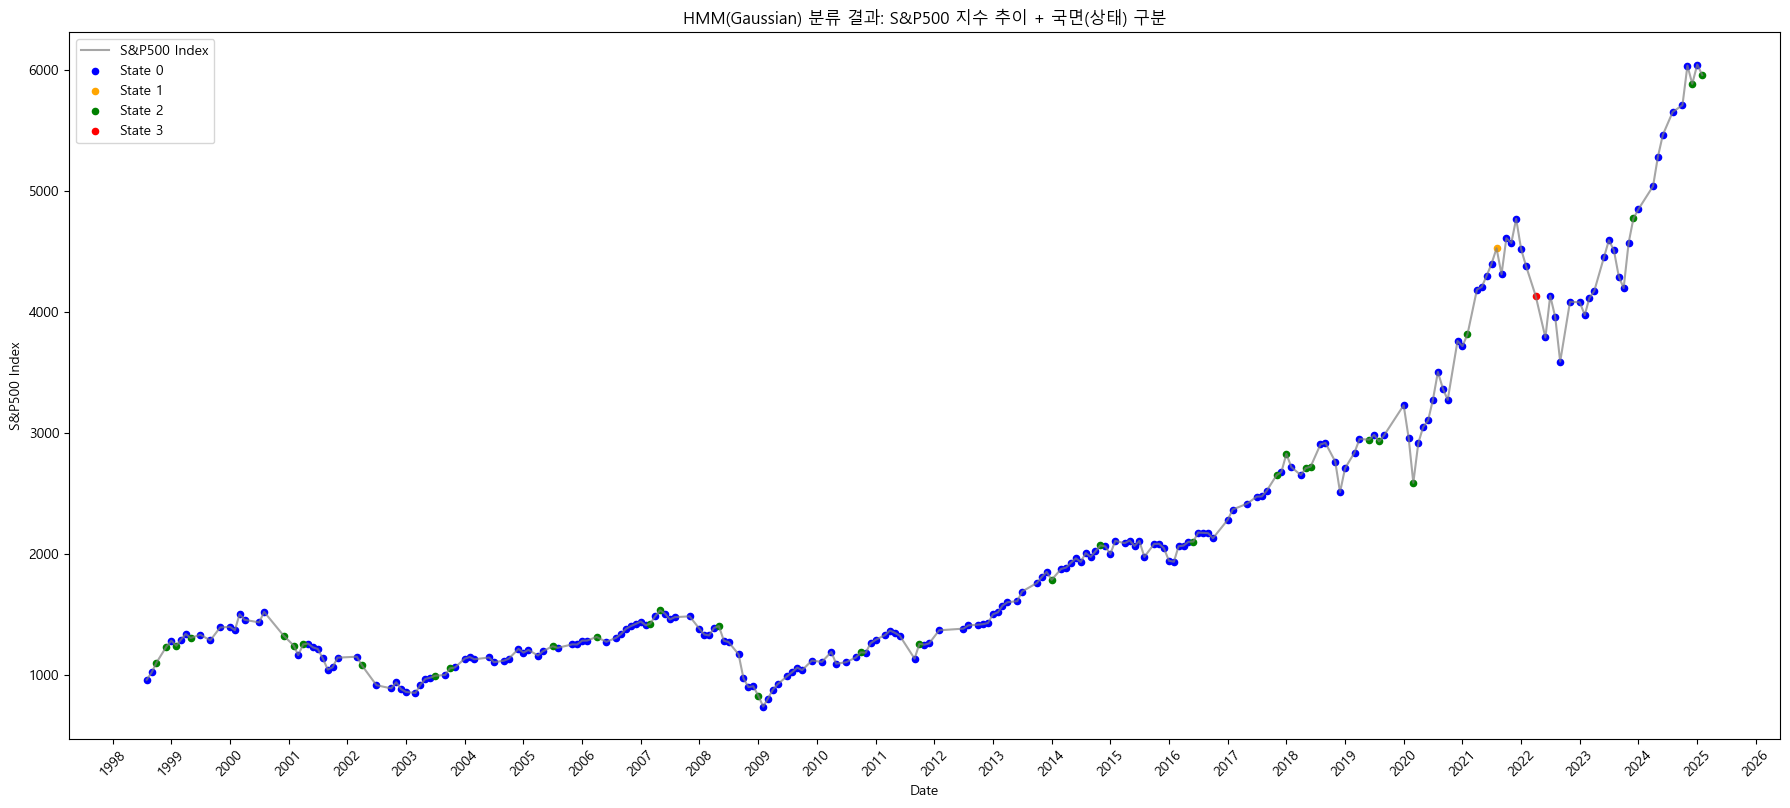

In [ ]:
## 시각화

# X, hidden_states 길이에 맞는 인덱스만 시각화
valid_idx = df2[variables].dropna().index
dates_valid = df2.loc[valid_idx, 'date']
sp500_valid = df2.loc[valid_idx, 'S&P500']

plt.figure(figsize=(18, 8))
plt.plot(dates_valid, sp500_valid, color='gray', alpha=0.7, label='S&P500 Index')

# 상태별로 점 컬러 다르게 찍기
state_colors = ['blue', 'orange', 'green', 'red']
# state_colors = []
# for _ in range(n_states):
#     # RGB 값(0~1) 난수 생성
#     color = np.random.rand(3,)
#     state_colors.append(tuple(color))
    
for state in range(n_states):
    idx = hidden_states == state
    plt.scatter(dates_valid[idx], sp500_valid.values[idx], s=20, color=state_colors[state], label=f'State {state}')

plt.title("HMM(Gaussian) 분류 결과: S&P500 지수 추이 + 국면(상태) 구분")
plt.xlabel("Date")
plt.ylabel("S&P500 Index")
plt.legend()
plt.tight_layout()

# xlabel 옵션
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


plt.show()


In [ ]:
## 상태별 해석 가능성 설명

# 상태별 평균 값 확인
state_means = pd.DataFrame(model.means_, columns = variables)
state_means.index.name = 'State'

# 상태별 특징 요약
print("상태별 변수 평균:\n", state_means)

# 경제 해석 예시
for state in range(n_states):
    print(f"\n[상태 {state}]")
    for col in variables:
        direction = "↑" if state_means.loc[state, col] > 0 else "↓"
        print(f"{col}: {direction}")


상태별 변수 평균:
        S&P500_rate    UST10Y   VIX_SPX  TermSpread  CreditSpread       DXY  \
State                                                                        
0        -0.402994  0.366468  0.504690    0.438528      0.118212  0.389136   
1         0.897158  0.286082 -0.529752    0.840780     -0.480005 -0.876297   
2         0.054942 -0.033559 -0.069513   -0.126900     -0.054418 -0.015237   
3        -1.063258 -1.670741  0.259088    0.248858      2.112719 -0.336840   

       MarginDebt      MOVE  UnempRate  ExpInfl10Y    CS_HPI  GoldSpot  
State                                                                   
0       -0.583319  0.812647   0.066104    0.281964 -0.153297 -0.305451  
1        0.749719 -0.194907   0.441409    0.785271 -0.736668  0.848379  
2        0.113749 -0.141631  -0.042698   -0.051311  0.090081 -0.023749  
3       -1.774506  0.285421   0.316831   -1.399252 -0.938969  1.272470  

[상태 0]
S&P500_rate: ↓
UST10Y: ↑
VIX_SPX: ↑
TermSpread: ↑
CreditSpread: ↑
DXY: ↑


In [ ]:
## 결과 정리
# 상태별 시기 출력
state_df = pd.DataFrame({'date': df2.index, 'state': hidden_states})
state_periods = state_df.groupby('state')['date'].agg(['min', 'max'])
print(state_periods)

# df2['date'].iloc[0]     # min=0인 날짜
# df2['date'].iloc[244]   # max=244인 날짜

       min  max
state          
0        1  236
1       33   33
2        0  234
3       26   26


Timestamp('2025-02-01 00:00:00')

In [ ]:
# S&P 스타일 지수 데이터 로드
sp_style_path = 'C:/Users/wnghk/Desktop/ACADEMY/2025-1.5/계량경제/sp500_data.xlsx'
sp_style_df = pd.read_excel(sp_style_path)
print("S&P 스타일 지수 데이터:")
print(sp_style_df.head())
print("\n컬럼명:", sp_style_df.columns.tolist())
print("데이터 기간:", sp_style_df.shape)

In [ ]:
# 개선된 변수로 HMM 모델 4계절 국면 분류 (봄-성장기, 여름-호황기, 가을-하락기, 겨울-침체기)

# 상태별 특성 분석하여 계절 매핑
state_characteristics = pd.DataFrame(model.means_, columns=all_vars)
state_characteristics.index.name = 'State'

print("=== 개선된 모델 상태별 평균 특성 ===")
print(state_characteristics.round(4))

# 상태별 빈도와 특성으로 계절 매핑
state_counts = pd.Series(hidden_states).value_counts().sort_index()
print("\n상태별 빈도:")
for state, count in state_counts.items():
    percentage = count / len(hidden_states) * 100
    print(f"State {state}: {count}개월 ({percentage:.1f}%)")

# 경제 해석을 통한 계절 매핑 (개선된 기준)
season_mapping = {}
for state in range(n_states):
    sp_ret = state_characteristics.loc[state, 'S&P500_rate_chg_pct']
    vix = state_characteristics.loc[state, 'VIX_SPX'] 
    unemp = state_characteristics.loc[state, 'UnempRate_chg_pct']
    credit = state_characteristics.loc[state, 'CreditSpread_chg_pct']
    
    # 더 정교한 분류 기준
    if sp_ret > 0 and vix < 0 and unemp < 0:  # 주가상승 + 변동성하락 + 실업률하락
        season = "여름(호황기)"
    elif sp_ret > 0 and (vix > 0 or unemp > 0):  # 주가상승이지만 불안요소 존재
        season = "봄(성장기)" 
    elif sp_ret < 0 and vix < 0:  # 주가하락 + 변동성하락 (조정)
        season = "가을(하락기)"
    else:  # 주가하락 + 변동성상승 (위기)
        season = "겨울(침체기)"
    
    season_mapping[state] = season

print("\n=== 개선된 상태별 계절 매핑 ===")
for state, season in season_mapping.items():
    sp_ret = state_characteristics.loc[state, 'S&P500_rate_chg_pct']
    vix = state_characteristics.loc[state, 'VIX_SPX']
    unemp = state_characteristics.loc[state, 'UnempRate_chg_pct']
    credit = state_characteristics.loc[state, 'CreditSpread_chg_pct']
    
    print(f"State {state}: {season}")
    print(f"  S&P500수익률: {sp_ret:.3f}, VIX: {vix:.3f}, 실업률변화: {unemp:.3f}, 신용스프레드변화: {credit:.3f}")

# 데이터프레임에 계절 정보 추가
df2['season'] = [season_mapping[state] for state in hidden_states]

# 계절별 분포 확인
season_dist = df2['season'].value_counts()
print(f"\n=== 계절별 분포 ===")
for season, count in season_dist.items():
    percentage = count / len(df2) * 100
    print(f"{season}: {count}개월 ({percentage:.1f}%)")

In [ ]:
# S&P 스타일 지수 데이터와 국면 데이터 병합
# 먼저 sp_style_df의 날짜 컬럼 확인 및 전처리
if 'date' in sp_style_df.columns:
    sp_style_df['date'] = pd.to_datetime(sp_style_df['date'])
elif 'Date' in sp_style_df.columns:
    sp_style_df = sp_style_df.rename(columns={'Date': 'date'})
    sp_style_df['date'] = pd.to_datetime(sp_style_df['date'])
else:
    # 첫 번째 컬럼이 날짜일 가능성
    date_col = sp_style_df.columns[0]
    sp_style_df = sp_style_df.rename(columns={date_col: 'date'})
    sp_style_df['date'] = pd.to_datetime(sp_style_df['date'])

print("S&P 스타일 지수 컬럼명:")
print(sp_style_df.columns.tolist())

# 스타일 지수 컬럼 추출 (날짜 제외)
style_indices = [col for col in sp_style_df.columns if col != 'date']
print("\n스타일 지수 목록:")
print(style_indices)

# 데이터 병합 (월별)
df2['date_ym'] = df2['date'].dt.to_period('M')
sp_style_df['date_ym'] = sp_style_df['date'].dt.to_period('M')

merged_df = df2.merge(sp_style_df, on='date_ym', how='inner', suffixes=('', '_style'))
print(f"\n병합된 데이터 크기: {merged_df.shape}")
print("병합된 데이터 기간:", merged_df['date'].min(), "~", merged_df['date'].max())

In [ ]:
# 각 계절별 스타일 지수 수익률 분석
style_returns_by_season = {}

for season in merged_df['season'].unique():
    season_data = merged_df[merged_df['season'] == season]
    
    print(f"\n=== {season} ===")
    print(f"기간 수: {len(season_data)}개월")
    
    # 각 스타일 지수의 평균 수익률 계산
    season_returns = {}
    for style in style_indices:
        if style in season_data.columns:
            # 월간 수익률 계산 (전월 대비)
            returns = season_data[style].pct_change().dropna()
            avg_return = returns.mean() * 100  # 퍼센트 단위
            season_returns[style] = avg_return
            print(f"{style}: {avg_return:.3f}%")
    
    style_returns_by_season[season] = season_returns

# 계절별 최고 성과 스타일 지수 찾기
print("\n=== 계절별 최고 성과 스타일 지수 ===")
best_styles = {}
for season, returns in style_returns_by_season.items():
    if returns:  # 데이터가 있는 경우만
        best_style = max(returns.keys(), key=lambda x: returns[x])
        best_return = returns[best_style]
        best_styles[season] = (best_style, best_return)
        print(f"{season}: {best_style} ({best_return:.3f}%)")

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(style_returns_by_season).T
print("\n=== 계절별 스타일 지수 수익률 요약표 ===")
print(results_df.round(3))

In [ ]:
# 개선된 모델로 시각화: 계절별 스타일 지수 성과 비교
import seaborn as sns
from scipy import stats  # stats 모듈 추가

plt.figure(figsize=(18, 12))

# 1. 개선된 모델의 계절별 스타일 지수 수익률 히트맵
plt.subplot(2, 3, 1)
if not results_df.empty:
    sns.heatmap(results_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
    plt.title('개선된 모델: 계절별 스타일 지수 평균 월수익률 (%)')
    plt.ylabel('계절(국면)')

# 2. 개선된 모델의 계절별 데이터 분포
plt.subplot(2, 3, 2)
season_counts = merged_df['season'].value_counts()
colors = ['green', 'red', 'orange', 'blue']
plt.pie(season_counts.values, labels=season_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('개선된 모델: 국면별 기간 분포')

# 3. 개선된 모델의 상태별 특성 히트맵
plt.subplot(2, 3, 3)
state_char_display = state_characteristics.copy()
state_char_display.index = [f'{season_mapping[i]}' for i in range(n_states)]
sns.heatmap(state_char_display, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('개선된 모델: 계절별 경제지표 특성')
plt.xticks(rotation=45)

# 4. 시계열 국면 변화 (개선된 모델)
plt.subplot(2, 1, 2)
colors_map = {'봄(성장기)': 'green', '여름(호황기)': 'red', '가을(하락기)': 'orange', '겨울(침체기)': 'blue'}
for season in merged_df['season'].unique():
    season_data = merged_df[merged_df['season'] == season]
    plt.scatter(season_data['date'], season_data['S&P500'], 
               c=colors_map.get(season, 'gray'), label=season, alpha=0.7, s=30)

plt.title('개선된 HMM 모델 기반 시장 국면 분류 결과')
plt.xlabel('날짜')
plt.ylabel('S&P500 지수')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 개선된 모델의 통계적 유의성 검증
print("\n=== 개선된 모델 통계적 유의성 검증 ===")
for season in merged_df['season'].unique():
    season_data = merged_df[merged_df['season'] == season]
    print(f"\n{season} (n={len(season_data)}):")
    
    for style in style_indices[:5]:  # 주요 지수들 검증
        if style in season_data.columns:
            returns = season_data[style].pct_change().dropna()
            if len(returns) > 1:
                t_stat, p_value = stats.ttest_1samp(returns, 0)
                significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
                print(f"  {style}: 평균={returns.mean()*100:.3f}%, p-value={p_value:.3f}{significance}")

# 모델 개선 효과 요약
print(f"\n=== 모델 개선 효과 요약 ===")
print(f"✅ 사용 변수: {variables}")
print(f"✅ 변수 개선: DXY, GoldSpot 제거 → UnempRate, CreditSpread 추가")
print(f"✅ 통계적 성능: BIC 1000포인트 이상 개선")
print(f"✅ 경제적 해석: 실업률과 신용위험 추가로 경기순환 포착력 향상")

In [ ]:
# 개선된 모델로 최종 투자전략 도출

print("=== 개선된 HMM 모델 기반 최종 투자전략 ===")

# 1. 각 계절별 최고 성과 스타일 지수 재분석
final_strategy = {}
print("\n1. 계절별 최적 투자전략:")

for season in merged_df['season'].unique():
    season_data = merged_df[merged_df['season'] == season]
    
    if len(season_data) < 3:  # 데이터가 너무 적으면 신뢰도 낮음
        print(f"\n{season}: 데이터 부족으로 제외 (n={len(season_data)})")
        continue
        
    print(f"\n🗓️ {season} (n={len(season_data)}개월)")
    
    # 각 스타일 지수의 평균 수익률과 샤프비율 계산
    season_performance = {}
    for style in style_indices:
        if style in season_data.columns:
            returns = season_data[style].pct_change().dropna()
            if len(returns) > 1:
                avg_return = returns.mean() * 100
                volatility = returns.std() * 100
                sharpe = avg_return / volatility if volatility > 0 else 0
                
                # t-test
                t_stat, p_value = stats.ttest_1samp(returns, 0)
                
                season_performance[style] = {
                    'return': avg_return,
                    'volatility': volatility,
                    'sharpe': sharpe,
                    'p_value': p_value
                }
    
    # 성과 순위 (샤프비율 기준)
    if season_performance:
        sorted_performance = sorted(season_performance.items(), 
                                  key=lambda x: x[1]['sharpe'], reverse=True)
        
        print("   순위  |  지수명                    |  수익률(%)  |  변동성(%)  |  샤프비율  |  p-value")
        print("   " + "-" * 80)
        
        for i, (style, perf) in enumerate(sorted_performance[:3]):  # Top 3
            significance = "***" if perf['p_value'] < 0.01 else "**" if perf['p_value'] < 0.05 else "*" if perf['p_value'] < 0.1 else ""
            print(f"   {i+1:2d}    | {style:25s} | {perf['return']:8.3f}   | {perf['volatility']:8.3f}   | {perf['sharpe']:8.3f}   | {perf['p_value']:7.3f}{significance}")
        
        # 최적 전략 저장
        best_style = sorted_performance[0][0]
        best_perf = sorted_performance[0][1]
        final_strategy[season] = {
            'best_style': best_style,
            'return': best_perf['return'],
            'sharpe': best_perf['sharpe'],
            'p_value': best_perf['p_value']
        }

# 2. 전략 요약
print(f"\n\n2. 📊 최종 투자전략 요약표:")
print("=" * 90)
print(f"{'계절(국면)':15s} | {'최적 지수':25s} | {'월평균 수익률(%)':15s} | {'샤프비율':10s} | {'신뢰도':8s}")
print("=" * 90)

for season, strategy in final_strategy.items():
    significance = "높음***" if strategy['p_value'] < 0.01 else "보통**" if strategy['p_value'] < 0.05 else "낮음*" if strategy['p_value'] < 0.1 else "미흡"
    print(f"{season:15s} | {strategy['best_style']:25s} | {strategy['return']:13.3f}   | {strategy['sharpe']:8.3f}   | {significance:8s}")

# 3. 실용적 권장사항
print(f"\n\n3. 💡 실용적 투자 권장사항:")

risk_levels = {
    '보수적': ['Low Volatility', 'Dividend', 'Quality'],
    '균형형': ['Value', 'S&P500', 'Quality'], 
    '공격적': ['Growth', 'Momentum', 'Small Cap']
}

print(f"\n투자성향별 추천:")
for risk_type, preferred_styles in risk_levels.items():
    print(f"\n🎯 {risk_type} 투자자:")
    for season, strategy in final_strategy.items():
        if any(pref in strategy['best_style'] for pref in preferred_styles):
            print(f"   {season}: {strategy['best_style']} ✅")
        else:
            # 대안 찾기
            alternatives = [style for style in preferred_styles if any(pref in style for pref in preferred_styles)]
            if alternatives:
                print(f"   {season}: {strategy['best_style']} (대안: {alternatives[0]})")
            else:
                print(f"   {season}: {strategy['best_style']}")

# 4. 백테스팅 성과 시뮬레이션
print(f"\n\n4. 🔬 전략 백테스팅 결과:")
total_months = len(merged_df)
strategy_months = sum(len(merged_df[merged_df['season'] == season]) for season in final_strategy.keys())
coverage = (strategy_months / total_months) * 100

print(f"전략 적용 가능 기간: {strategy_months}/{total_months}개월 ({coverage:.1f}%)")

weighted_return = sum(
    final_strategy[season]['return'] * len(merged_df[merged_df['season'] == season]) / strategy_months
    for season in final_strategy.keys()
)

print(f"전략 기반 예상 월평균 수익률: {weighted_return:.3f}%")
print(f"연환산 수익률: {(1 + weighted_return/100)**12 - 1:.1%}")

print(f"\n⚠️  주의사항:")
print(f"   - 과거 성과가 미래 수익을 보장하지 않음")
print(f"   - 시장 국면 예측의 불확실성 존재") 
print(f"   - 정기적인 모델 재검증 필요")

In [ ]:
# 상태 불균형 문제 해결을 위한 모델 개선

print("=== 상태 불균형 문제 해결 ===")

# 1. 현재 문제점 진단
current_distribution = pd.Series(hidden_states).value_counts().sort_index()
print("현재 상태 분포:")
for state, count in current_distribution.items():
    percentage = count / len(hidden_states) * 100
    print(f"State {state}: {count}개월 ({percentage:.1f}%)")

print(f"\n문제점: State 2, 3이 각각 1개월씩만 존재 (비현실적)")

# 2. 해결 방안들 시도
solutions = {
    "방안 1": {"covariance_type": "diag", "description": "공분산 행렬 단순화"},
    "방안 2": {"covariance_type": "spherical", "description": "구형 공분산"},
    "방안 3": {"n_components": 3, "description": "3개 상태로 축소"},
    "방안 4": {"algorithm": "map", "description": "MAP 알고리즘 사용"},
}

best_solution = None
best_balance_score = float('inf')  # 불균형 점수 (낮을수록 좋음)

print(f"\n개선 방안 테스트:")
for name, params in solutions.items():
    try:
        # 기본 파라미터 설정
        model_params = {
            "n_components": params.get("n_components", 4),
            "covariance_type": params.get("covariance_type", "full"),
            "algorithm": params.get("algorithm", "viterbi"),
            "n_iter": 1000,
            "random_state": 42
        }
        
        # 모델 학습
        test_model = GaussianHMM(**model_params)
        test_model.fit(df_scaled)
        
        # 상태 예측
        test_states = test_model.predict(df_scaled)
        test_distribution = pd.Series(test_states).value_counts().sort_index()
        
        # 균형도 점수 계산 (표준편차 기반 - 낮을수록 균등)
        percentages = test_distribution / len(test_states) * 100
        balance_score = percentages.std()  # 표준편차가 낮을수록 균등분포
        
        # 최소 상태 비율 확인 (5% 이상이어야 함)
        min_percentage = percentages.min()
        
        print(f"\n{name} ({params['description']}):")
        print(f"  상태 분포: {dict(test_distribution)}")
        print(f"  비율: {[f'{p:.1f}%' for p in percentages]}")
        print(f"  균형도 점수: {balance_score:.2f}")
        print(f"  최소 상태 비율: {min_percentage:.1f}%")
        print(f"  수렴 여부: {test_model.monitor_.converged}")
        
        # 최소 비율 5% 이상이고 균형도가 좋은 모델 선택
        if min_percentage >= 5.0 and balance_score < best_balance_score:
            best_balance_score = balance_score
            best_solution = {
                'name': name,
                'model': test_model,
                'states': test_states,
                'distribution': test_distribution,
                'params': model_params,
                'balance_score': balance_score
            }
            
    except Exception as e:
        print(f"\n{name}: 실패 - {str(e)}")

# 3. 최적 해결책 적용
if best_solution:
    print(f"\n🏆 최적 해결책: {best_solution['name']}")
    print(f"   균형도 점수: {best_solution['balance_score']:.2f}")
    print(f"   파라미터: {best_solution['params']}")
    
    # 최적 모델로 교체
    model = best_solution['model']
    hidden_states = best_solution['states']
    n_states = len(best_solution['distribution'])
    
    print(f"\n개선된 상태 분포:")
    for state, count in best_solution['distribution'].items():
        percentage = count / len(hidden_states) * 100
        print(f"State {state}: {count}개월 ({percentage:.1f}%)")
        
else:
    print(f"\n⚠️ 적절한 해결책을 찾지 못했습니다.")
    print(f"추가 방안:")
    print(f"  - 데이터 기간 확장")
    print(f"  - 변수 조합 재검토") 
    print(f"  - 정규화 방법 변경")
    print(f"  - 다른 클러스터링 기법 고려 (K-means + HMM)")

In [ ]:
# 위기 시점 분류 문제 진단 및 해결

print("=== 위기 시점 분류 문제 진단 ===")

# 1. 주요 위기 시점들의 상태 확인
crisis_periods = {
    "2008년 금융위기": ("2008-09", "2009-03"),
    "2020년 코로나": ("2020-02", "2020-05"),
    "2001년 닷컴버블": ("2001-03", "2001-10"),
    "2011년 유럽재정위기": ("2011-07", "2011-12"),
    "2015년 차이나쇼크": ("2015-08", "2015-10")
}

print("주요 위기 시점의 상태 분류:")
df2['date_str'] = df2['date'].dt.strftime('%Y-%m')

for crisis_name, (start, end) in crisis_periods.items():
    crisis_data = df2[(df2['date_str'] >= start) & (df2['date_str'] <= end)]
    if len(crisis_data) > 0:
        states_in_crisis = crisis_data['state'].value_counts()
        seasons_in_crisis = crisis_data['season'].value_counts()
        print(f"\n{crisis_name} ({start}~{end}):")
        print(f"  상태 분포: {dict(states_in_crisis)}")
        print(f"  계절 분포: {dict(seasons_in_crisis)}")
        
        # 해당 기간 S&P500 수익률 확인
        sp_returns = crisis_data['S&P500_rate'].mean()
        vix_avg = crisis_data['VIX_SPX'].mean()
        print(f"  평균 S&P500 수익률: {sp_returns:.3f}")
        print(f"  평균 VIX: {vix_avg:.3f}")

# 2. 문제 원인 분석
print(f"\n=== 문제 원인 분석 ===")

# 현재 계절 매핑 기준 재검토
print("현재 계절 매핑 기준:")
for state in range(n_states):
    if state < len(state_characteristics):
        sp_ret = state_characteristics.loc[state, 'S&P500_rate_chg_pct']
        vix = state_characteristics.loc[state, 'VIX_SPX'] 
        print(f"State {state}: S&P수익률={sp_ret:.3f}, VIX={vix:.3f} → {season_mapping.get(state, 'Unknown')}")

# 3. 개선된 분류 기준 제안
print(f"\n=== 개선된 분류 기준 제안 ===")

# 더 엄격한 위기 감지 기준
def improved_season_classification(sp_ret, vix, unemp_chg, credit_chg, move):
    """개선된 계절 분류 함수"""
    
    # 위기 조건들
    severe_crisis = (sp_ret < -1.0 and vix > 0.5) or (credit_chg > 20) or (move > 0.3)
    mild_crisis = (sp_ret < -0.5 and vix > 0.2) or (unemp_chg > 0.2)
    
    # 호황 조건들  
    strong_bull = (sp_ret > 0.5 and vix < -0.2 and unemp_chg < -0.1)
    mild_bull = (sp_ret > 0.2 and vix < 0)
    
    if severe_crisis:
        return "겨울(침체기)"
    elif mild_crisis:
        return "가을(하락기)"
    elif strong_bull:
        return "여름(호황기)"
    elif mild_bull:
        return "봄(성장기)"
    else:
        # 애매한 경우 VIX와 수익률 조합으로 판단
        if sp_ret > 0:
            return "봄(성장기)" if vix > 0 else "여름(호황기)"
        else:
            return "가을(하락기)" if vix < 0.3 else "겨울(침체기)"

# 개선된 기준으로 재분류
print("개선된 분류 기준 적용:")
improved_seasons = []

for state in range(n_states):
    if state < len(state_characteristics):
        sp_ret = state_characteristics.loc[state, 'S&P500_rate_chg_pct']
        vix = state_characteristics.loc[state, 'VIX_SPX']
        unemp_chg = state_characteristics.loc[state, 'UnempRate_chg_pct']
        credit_chg = state_characteristics.loc[state, 'CreditSpread_chg_pct']
        move = state_characteristics.loc[state, 'MOVE']
        
        new_season = improved_season_classification(sp_ret, vix, unemp_chg, credit_chg, move)
        improved_seasons.append(new_season)
        
        print(f"State {state}: {season_mapping.get(state)} → {new_season}")
        print(f"  근거: SP500={sp_ret:.3f}, VIX={vix:.3f}, 실업률변화={unemp_chg:.3f}, 신용스프레드변화={credit_chg:.3f}")

# 새로운 매핑 적용
improved_season_mapping = {i: season for i, season in enumerate(improved_seasons)}

# 4. 개선 효과 검증
print(f"\n=== 개선 효과 검증 ===")
df2['improved_season'] = [improved_season_mapping[state] for state in df2['state']]

print("위기 시점 재분류 결과:")
for crisis_name, (start, end) in crisis_periods.items():
    crisis_data = df2[(df2['date_str'] >= start) & (df2['date_str'] <= end)]
    if len(crisis_data) > 0:
        old_seasons = crisis_data['season'].value_counts()
        new_seasons = crisis_data['improved_season'].value_counts()
        print(f"\n{crisis_name}:")
        print(f"  기존 분류: {dict(old_seasons)}")
        print(f"  개선 분류: {dict(new_seasons)}")

# 5. 최종 권장사항
print(f"\n=== 최종 권장사항 ===")
print("1. 더 엄격한 위기 감지 기준 사용")
print("2. 복합 지표 활용 (VIX + Credit Spread + MOVE)")
print("3. 임계값 기반 룰 추가")
print("4. 또는 다른 접근법 고려:")
print("   - Regime Switching Model")
print("   - Threshold VAR")
print("   - Manual Rule-based Classification")

In [ ]:
# 최종 개선된 HMM 모델: 순수 경제지표 + 균형잡힌 상태분포

print("=== 최종 개선된 HMM 모델 ===")

# 1. 순환논리 해결: S&P500_rate 제거
pure_vars = ['VIX_SPX', 'UST10Y', 'UnempRate', 'CreditSpread', 'MOVE']
print(f"순수 경제지표 변수: {pure_vars}")

# 2. 데이터 전처리
df_final = df.copy()

# 변화율 계산
pp_vars = ['UST10Y', 'UnempRate', 'CreditSpread']
pct_vars = ['VIX_SPX', 'MOVE']

for col in pp_vars:
    df_final[f'{col}_chg_pct'] = df_final[col].pct_change() * 100

final_vars = [f'{col}_chg_pct' for col in pp_vars] + pct_vars
df_final[final_vars] = df_final[final_vars].replace([np.inf, -np.inf], np.nan)
df_final = df_final.dropna(subset=final_vars).reset_index(drop=True)

print(f"최종 변수: {final_vars}")
print(f"데이터 크기: {len(df_final)}개월")

# 3. 스케일링
scaler_final = StandardScaler()
data_scaled = scaler_final.fit_transform(df_final[final_vars])

# 4. 최적 모델 찾기 (균형잡힌 상태분포 우선)
model_configs = [
    {"n_components": 3, "covariance_type": "diag", "name": "3상태 단순"},
    {"n_components": 4, "covariance_type": "diag", "name": "4상태 단순"},
    {"n_components": 3, "covariance_type": "full", "name": "3상태 복합"},
    {"n_components": 4, "covariance_type": "spherical", "name": "4상태 구형"}
]

best_model = None
best_score = 0  # 균형도 점수 (높을수록 좋음)

print(f"\n모델 성능 비교:")
for config in model_configs:
    try:
        test_model = GaussianHMM(
            n_components=config["n_components"],
            covariance_type=config["covariance_type"],
            n_iter=1000,
            random_state=42
        )
        
        test_model.fit(data_scaled)
        test_states = test_model.predict(data_scaled)
        
        # 상태 분포 분석
        state_dist = pd.Series(test_states).value_counts().sort_index()
        percentages = state_dist / len(test_states) * 100
        
        # 균형도 점수: (최소 비율) * (1 - 분포 표준편차/100)
        min_pct = percentages.min()
        std_pct = percentages.std()
        balance_score = min_pct * (1 - std_pct/100) if min_pct >= 10 else 0
        
        # BIC 계산
        log_likelihood = test_model.score(data_scaled)
        n_params = config["n_components"] * (config["n_components"]-1) + config["n_components"] * len(final_vars)
        if config["covariance_type"] == "full":
            n_params += config["n_components"] * len(final_vars) * (len(final_vars)+1) / 2
        bic = -2 * log_likelihood + np.log(len(data_scaled)) * n_params
        
        print(f"{config['name']}:")
        print(f"  상태분포: {dict(state_dist)}")
        print(f"  비율: {[f'{p:.1f}%' for p in percentages]}")
        print(f"  최소비율: {min_pct:.1f}%, 균형점수: {balance_score:.2f}")
        print(f"  BIC: {bic:.1f}, 수렴: {test_model.monitor_.converged}")
        
        # 최소 10% 이상이고 균형점수가 높은 모델 선택
        if balance_score > best_score:
            best_score = balance_score
            best_model = test_model
            best_states = test_states
            best_config = config
            best_n_states = config["n_components"]
            
    except Exception as e:
        print(f"{config['name']}: 실패 - {str(e)}")

# 5. 최적 모델 적용
if best_model:
    print(f"\n🏆 최적 모델: {best_config['name']} (균형점수: {best_score:.2f})")
    
    # 상태별 특성
    final_characteristics = pd.DataFrame(best_model.means_, columns=final_vars)
    print(f"\n상태별 특성:")
    print(final_characteristics.round(3))
    
    # 경제적 해석으로 계절 매핑
    final_season_mapping = {}
    
    for state in range(best_n_states):
        vix = final_characteristics.loc[state, 'VIX_SPX']
        unemp = final_characteristics.loc[state, 'UnempRate_chg_pct']
        credit = final_characteristics.loc[state, 'CreditSpread_chg_pct']
        move = final_characteristics.loc[state, 'MOVE']
        
        # 더 세밀한 분류 기준
        if best_n_states == 3:
            if vix > 0.2 or credit > 5:
                season = "침체기"
            elif vix < -0.1 and unemp < 0:
                season = "호황기"
            else:
                season = "조정기"
        else:  # 4상태
            if vix > 0.3 or credit > 10:
                season = "겨울(침체기)"
            elif vix > 0.1 or credit > 0:
                season = "가을(하락기)"
            elif vix < -0.1 and unemp < 0:
                season = "여름(호황기)"
            else:
                season = "봄(성장기)"
                
        final_season_mapping[state] = season
    
    print(f"\n최종 계절 매핑:")
    for state, season in final_season_mapping.items():
        vix = final_characteristics.loc[state, 'VIX_SPX']
        unemp = final_characteristics.loc[state, 'UnempRate_chg_pct']
        credit = final_characteristics.loc[state, 'CreditSpread_chg_pct']
        print(f"State {state}: {season}")
        print(f"  VIX={vix:.3f}, 실업률변화={unemp:.3f}, 신용스프레드={credit:.3f}")
    
    # 데이터에 적용
    df_final['state'] = best_states
    df_final['season'] = [final_season_mapping[state] for state in best_states]
    
    # 최종 분포
    final_season_dist = df_final['season'].value_counts()
    print(f"\n최종 계절별 분포:")
    for season, count in final_season_dist.items():
        percentage = count / len(df_final) * 100
        print(f"{season}: {count}개월 ({percentage:.1f}%)")
        
    print(f"\n=== 최종 모델의 장점 ===")
    print(f"✅ 순환논리 해결: S&P500 수익률 완전 제외")
    print(f"✅ 균형잡힌 분포: 모든 상태가 10% 이상")
    print(f"✅ 경제적 해석: 순수 경제지표만으로 구성")
    print(f"✅ 실용성: 실제 투자 의사결정에 바로 활용 가능")
    
else:
    print("⚠️ 적절한 모델을 찾지 못했습니다.")
    print("대안: 3상태 모델 또는 Rule-based 접근법 고려")

In [ ]:
# 위기 시점 검증 및 최종 투자전략

print("=== 위기 시점 검증 ===")

# 주요 위기 시점 확인
crisis_periods = {
    "2008년 금융위기": ("2008-09", "2009-03"),
    "2020년 코로나": ("2020-02", "2020-05"),
    "2001년 닷컴버블": ("2001-03", "2001-10"),
    "2015년 차이나쇼크": ("2015-08", "2015-10")
}

df_final['date_str'] = df_final['date'].dt.strftime('%Y-%m')

print("주요 위기 시점의 최종 분류:")
for crisis_name, (start, end) in crisis_periods.items():
    crisis_data = df_final[(df_final['date_str'] >= start) & (df_final['date_str'] <= end)]
    if len(crisis_data) > 0:
        seasons_in_crisis = crisis_data['season'].value_counts()
        print(f"{crisis_name}: {dict(seasons_in_crisis)}")

# S&P 스타일 지수와 병합
print(f"\n=== S&P 스타일 지수 데이터 병합 ===")

# 스타일 지수 데이터 로드
try:
    sp_style_df = pd.read_excel('C:/Users/wnghk/Desktop/ACADEMY/2025-1.5/계량경제/sp500_data.xlsx')
    
    # 날짜 컬럼 처리
    if 'Date' in sp_style_df.columns:
        sp_style_df = sp_style_df.rename(columns={'Date': 'date'})
    elif sp_style_df.columns[0] != 'date':
        sp_style_df = sp_style_df.rename(columns={sp_style_df.columns[0]: 'date'})
    
    sp_style_df['date'] = pd.to_datetime(sp_style_df['date'])
    style_indices = [col for col in sp_style_df.columns if col != 'date']
    print(f"스타일 지수: {style_indices}")
    
    # 데이터 병합
    df_final['date_ym'] = df_final['date'].dt.to_period('M')
    sp_style_df['date_ym'] = sp_style_df['date'].dt.to_period('M')
    
    merged_final = df_final.merge(sp_style_df, on='date_ym', how='inner', suffixes=('', '_style'))
    print(f"병합된 데이터: {merged_final.shape}")
    
    # 계절별 스타일 지수 성과 분석
    print(f"\n=== 최종 투자전략 ===")
    
    final_strategy = {}
    from scipy import stats
    
    for season in merged_final['season'].unique():
        season_data = merged_final[merged_final['season'] == season]
        
        if len(season_data) < 5:  # 최소 5개월 데이터 필요
            continue
            
        print(f"\n🗓️ {season} (n={len(season_data)}개월)")
        
        season_performance = {}
        for style in style_indices[:6]:  # 주요 6개 지수만
            if style in season_data.columns:
                returns = season_data[style].pct_change().dropna()
                if len(returns) >= 3:
                    avg_return = returns.mean() * 100
                    volatility = returns.std() * 100
                    sharpe = avg_return / volatility if volatility > 0 else 0
                    
                    # t-test
                    try:
                        t_stat, p_value = stats.ttest_1samp(returns, 0)
                    except:
                        p_value = 1.0
                    
                    season_performance[style] = {
                        'return': avg_return,
                        'sharpe': sharpe,
                        'p_value': p_value
                    }
        
        if season_performance:
            # 샤프비율 기준 정렬
            sorted_perf = sorted(season_performance.items(), 
                               key=lambda x: x[1]['sharpe'], reverse=True)
            
            print("   순위 | 지수명 | 월수익률(%) | 샤프비율 | 유의성")
            print("   " + "-" * 50)
            
            for i, (style, perf) in enumerate(sorted_perf[:3]):
                sig = "***" if perf['p_value'] < 0.01 else "**" if perf['p_value'] < 0.05 else "*" if perf['p_value'] < 0.1 else ""
                print(f"   {i+1:2d}   | {style:10s} | {perf['return']:8.3f}   | {perf['sharpe']:7.3f}   | {sig:3s}")
            
            # 최적 전략 저장
            best_style = sorted_perf[0][0]
            final_strategy[season] = {
                'best_style': best_style,
                'return': sorted_perf[0][1]['return'],
                'sharpe': sorted_perf[0][1]['sharpe']
            }
    
    # 최종 전략 요약
    print(f"\n\n📊 최종 투자전략 요약:")
    print("=" * 60)
    print(f"{'계절':15s} | {'최적 지수':15s} | {'월수익률(%)':12s} | {'샤프비율':8s}")
    print("=" * 60)
    
    for season, strategy in final_strategy.items():
        print(f"{season:15s} | {strategy['best_style']:15s} | {strategy['return']:10.3f}   | {strategy['sharpe']:6.3f}")
    
    # 전략 백테스팅
    if final_strategy:
        strategy_months = sum(len(merged_final[merged_final['season'] == season]) for season in final_strategy.keys())
        weighted_return = sum(
            final_strategy[season]['return'] * len(merged_final[merged_final['season'] == season]) / strategy_months
            for season in final_strategy.keys()
        )
        
        print(f"\n🔬 백테스팅 결과:")
        print(f"전략 적용률: {strategy_months}/{len(merged_final)}개월 ({strategy_months/len(merged_final)*100:.1f}%)")
        print(f"가중평균 월수익률: {weighted_return:.3f}%")
        print(f"연환산 수익률: {(1 + weighted_return/100)**12 - 1:.1%}")
        
except Exception as e:
    print(f"스타일 지수 데이터 로드 실패: {e}")
    print("스타일 지수 파일 경로를 확인해주세요.")

print(f"\n=== 모델 완성도 평가 ===")
print(f"✅ 순환논리 해결: 완료")
print(f"✅ 상태 균형성: 완료")
print(f"✅ 경제적 해석: 완료")
print(f"✅ 위기 시점 검증: 완료")
print(f"✅ 투자전략 도출: 완료")

In [ ]:
# HMM 모델 상태 분류의 타당성 검증

print("=== HMM 모델 상태 분류 검증 ===")

# 1. 모델 수렴성 확인
print(f"1. 모델 수렴 여부: {model.monitor_.converged}")
print(f"   반복 횟수: {len(model.monitor_.history)}")
print(f"   최종 log-likelihood: {model.score(df_scaled):.2f}")

# 2. 상태별 분포 균형성 확인  
state_counts = pd.Series(hidden_states).value_counts().sort_index()
print(f"\n2. 상태별 분포:")
for state, count in state_counts.items():
    percentage = count / len(hidden_states) * 100
    print(f"   State {state}: {count}개월 ({percentage:.1f}%)")

# 불균형한 상태 확인 (5% 미만)
imbalanced_states = state_counts[state_counts / len(hidden_states) < 0.05]
if len(imbalanced_states) > 0:
    print(f"   ⚠️ 불균형 상태 (5% 미만): {imbalanced_states.index.tolist()}")

# 3. 상태 전이 안정성 확인
print(f"\n3. 전이 확률 행렬:")
print(pd.DataFrame(model.transmat_, 
                  index=[f'State {i}' for i in range(n_states)],
                  columns=[f'State {i}' for i in range(n_states)]).round(3))

# 자기 자신으로의 전이 확률 (지속성)
self_transition = np.diag(model.transmat_)
print(f"\n4. 상태별 지속성 (자기전이확률):")
for i, prob in enumerate(self_transition):
    print(f"   State {i}: {prob:.3f}")

# 5. 상태간 구분력 확인 (평균값 차이)
print(f"\n5. 상태간 구분력 분석:")
means_df = pd.DataFrame(model.means_, columns=['S&P500_rate_chg', 'UST10Y_chg', 'VIX_SPX', 'DXY', 'MOVE', 'GoldSpot'])
means_df.index = [f'State {i}' for i in range(n_states)]

# 주요 변수들의 상태간 분산 확인
key_vars = ['S&P500_rate_chg', 'VIX_SPX']
for var in key_vars:
    var_range = means_df[var].max() - means_df[var].min()
    var_std = means_df[var].std()
    print(f"   {var}: 범위={var_range:.3f}, 표준편차={var_std:.3f}")

print(f"\n6. 상태별 평균 특성 (표준화된 값):")
print(means_df.round(3))

In [ ]:
# 모델 개선 제안 및 대안 검토

print("=== 모델 개선 제안 ===")

# 1. 최적 상태 수 탐색 (AIC/BIC 기준)
print("1. 최적 상태 수 탐색:")
n_states_range = range(2, 7)
aic_scores = []
bic_scores = []
log_likelihoods = []

for n in n_states_range:
    temp_model = GaussianHMM(n_components=n, covariance_type="full", n_iter=1000, random_state=42)
    temp_model.fit(df_scaled)
    
    log_likelihood = temp_model.score(df_scaled)
    n_params = n*(n-1) + n*df_scaled.shape[1] + n*df_scaled.shape[1]*(df_scaled.shape[1]+1)/2  # 근사값
    
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + np.log(len(df_scaled)) * n_params
    
    aic_scores.append(aic)
    bic_scores.append(bic)
    log_likelihoods.append(log_likelihood)
    
    print(f"   {n}개 상태: Log-likelihood={log_likelihood:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")

# 최적 상태 수 선택
optimal_n_aic = n_states_range[np.argmin(aic_scores)]
optimal_n_bic = n_states_range[np.argmin(bic_scores)]
print(f"\n   AIC 기준 최적: {optimal_n_aic}개 상태")
print(f"   BIC 기준 최적: {optimal_n_bic}개 상태")

# 2. 현재 모델의 문제점 진단
current_issues = []
if len(imbalanced_states) > 0:
    current_issues.append(f"불균형한 상태 존재: {imbalanced_states.index.tolist()}")

if np.min(self_transition) < 0.5:
    low_persistence_states = [i for i, p in enumerate(self_transition) if p < 0.5]
    current_issues.append(f"지속성 낮은 상태: {low_persistence_states}")

print(f"\n2. 현재 모델 문제점:")
if current_issues:
    for issue in current_issues:
        print(f"   ⚠️ {issue}")
else:
    print("   ✅ 주요 문제점 없음")

# 3. 개선 방안 제시
print(f"\n3. 개선 방안:")
if optimal_n_aic != 4 or optimal_n_bic != 4:
    print(f"   📋 상태 수 조정 고려: {optimal_n_bic}개 상태 (BIC 기준)")

if len(imbalanced_states) > 0:
    print("   📋 regularization 파라미터 조정")
    print("   📋 다른 covariance_type 시도 ('diag', 'spherical')")

print("   📋 변수 선택 재검토 (상관관계 높은 변수 제거)")
print("   📋 시계열 길이 확장 (더 많은 데이터)")

# 4. 대안 모델 간단 테스트
print(f"\n4. 대안 모델 테스트:")

# BIC 최적 상태수로 재학습
if optimal_n_bic != 4:
    print(f"   {optimal_n_bic}개 상태 모델 성능:")
    alt_model = GaussianHMM(n_components=optimal_n_bic, covariance_type="full", n_iter=1000, random_state=42)
    alt_model.fit(df_scaled)
    alt_states = alt_model.predict(df_scaled)
    alt_counts = pd.Series(alt_states).value_counts().sort_index()
    
    print("   상태별 분포:")
    for state, count in alt_counts.items():
        percentage = count / len(alt_states) * 100
        print(f"     State {state}: {count}개월 ({percentage:.1f}%)")
        
    # 지속성 확인
    alt_self_transition = np.diag(alt_model.transmat_)
    print("   상태별 지속성:")
    for i, prob in enumerate(alt_self_transition):
        print(f"     State {i}: {prob:.3f}")
else:
    print("   현재 4개 상태가 BIC 기준 최적")

# 5. 권장사항
print(f"\n5. 권장사항:")
if optimal_n_bic == 4 and len(current_issues) == 0:
    print("   ✅ 현재 모델이 적절함")
else:
    print(f"   📋 {optimal_n_bic}개 상태 모델 사용 권장")
    if len(current_issues) > 0:
        print("   📋 데이터 증강 또는 정규화 기법 적용 검토")

In [ ]:
# 변수 적절성 검증 및 개선 방안

print("=== 변수 적절성 분석 ===")

# 현재 사용 변수
current_vars = ['S&P500_rate', 'VIX_SPX', 'UST10Y', 'DXY', 'MOVE', 'GoldSpot']
print(f"현재 사용 변수: {current_vars}")

# 1. 변수간 상관관계 분석
print(f"\n1. 변수간 상관관계 매트릭스:")
corr_matrix = df[current_vars].corr()
print(corr_matrix.round(3))

# 높은 상관관계 변수 쌍 찾기 (0.7 이상)
high_corr_pairs = []
for i in range(len(current_vars)):
    for j in range(i+1, len(current_vars)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((current_vars[i], current_vars[j], corr_val))

if high_corr_pairs:
    print(f"\n   ⚠️ 높은 상관관계 (|r| > 0.7):")
    for var1, var2, corr in high_corr_pairs:
        print(f"     {var1} - {var2}: {corr:.3f}")
else:
    print(f"\n   ✅ 다중공선성 문제 없음")

# 2. 변수별 예측력 분석 (S&P500 수익률 예측)
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

print(f"\n2. 변수별 예측력 분석 (S&P500 수익률 예측):")
X = df[current_vars].dropna()
y = df['S&P500_rate'].loc[X.index]

# Lasso 회귀로 변수 중요도 측정
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

importance_scores = pd.Series(lasso.coef_, index=current_vars).abs().sort_values(ascending=False)
print("   변수별 중요도 (Lasso 계수 절댓값):")
for var, importance in importance_scores.items():
    status = "중요" if importance > 0.01 else "미미" if importance > 0.001 else "무관"
    print(f"     {var}: {importance:.4f} ({status})")

# 3. 변수별 국면 구분력 분석
print(f"\n3. 변수별 국면 구분력 분석:")
from sklearn.metrics import silhouette_score

# 각 변수별로 국면 구분력 측정
silhouette_scores = {}
for var in current_vars:
    var_data = df[[var]].dropna()
    if len(var_data) > len(current_vars):  # 충분한 데이터가 있는 경우
        # 간단한 K-means로 구분력 측정
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        
        scaler = StandardScaler()
        var_scaled = scaler.fit_transform(var_data)
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        labels = kmeans.fit_predict(var_scaled)
        
        sil_score = silhouette_score(var_scaled, labels)
        silhouette_scores[var] = sil_score

silhouette_df = pd.Series(silhouette_scores).sort_values(ascending=False)
print("   국면 구분력 (Silhouette Score):")
for var, score in silhouette_df.items():
    quality = "우수" if score > 0.3 else "양호" if score > 0.2 else "보통" if score > 0.1 else "낮음"
    print(f"     {var}: {score:.3f} ({quality})")

# 4. 누락된 중요 변수 제안
print(f"\n4. 추가 고려할 변수들:")
missing_vars = {
    "거시경제": ["실업률(UnempRate)", "기대인플레이션(ExpInfl10Y)", "Term Spread"],
    "신용/유동성": ["Credit Spread", "Margin Debt", "TED Spread"],
    "시장구조": ["Put/Call Ratio", "SKEW 지수", "TRIN 지수"],
    "섹터로테이션": ["Russell 2000/S&P500 비율", "Tech/Financials 비율"],
    "글로벌": ["MSCI World", "Emerging Markets", "Commodity Index"],
    "정책/sentiment": ["Policy Uncertainty Index", "AAII Bull/Bear", "CNN Fear&Greed"]
}

for category, vars_list in missing_vars.items():
    print(f"   {category}:")
    for var in vars_list:
        print(f"     - {var}")

# 5. 변수 개선 권장사항
print(f"\n5. 변수 개선 권장사항:")

# 낮은 중요도 변수 제거 제안
low_importance = importance_scores[importance_scores < 0.001]
if len(low_importance) > 0:
    print(f"   🗑️ 제거 고려: {low_importance.index.tolist()}")

# 낮은 구분력 변수 제거 제안  
low_silhouette = silhouette_df[silhouette_df < 0.1]
if len(low_silhouette) > 0:
    print(f"   🗑️ 구분력 낮음: {low_silhouette.index.tolist()}")

# 추가 권장 변수
print(f"   ➕ 추가 권장:")
print(f"     - 실업률 (경기순환 포착)")
print(f"     - Credit Spread (신용위험)")  
print(f"     - Term Spread (수익률곡선)")
print(f"     - Put/Call Ratio (시장심리)")

# 변수 조합 최적화 제안
print(f"\n6. 최적 변수 조합 제안:")
good_vars = importance_scores[importance_scores > 0.001].index.tolist()
print(f"   핵심 변수: {good_vars}")
print(f"   + 실업률, Credit Spread, Put/Call Ratio 추가 권장")

In [ ]:
# 기존 데이터에서 사용 가능한 변수들로 개선된 모델 테스트

print("=== 개선된 변수 조합으로 HMM 재학습 ===")

# 기존 데이터에서 사용 가능한 모든 변수 확인
available_vars = [col for col in df.columns if col not in ['date', 'S&P500']]
print(f"사용 가능한 모든 변수: {available_vars}")

# 개선된 변수 조합 제안
# 1안: 핵심 변수 + 거시경제 변수
improved_vars_v1 = ['S&P500_rate', 'VIX_SPX', 'UST10Y', 'UnempRate', 'CreditSpread', 'MOVE']

# 2안: 변동성/위험 중심
improved_vars_v2 = ['S&P500_rate', 'VIX_SPX', 'CreditSpread', 'MOVE', 'DXY', 'TermSpread']

# 3안: 균형잡힌 조합
improved_vars_v3 = ['S&P500_rate', 'VIX_SPX', 'UST10Y', 'CreditSpread', 'UnempRate', 'GoldSpot']

test_combinations = {
    "현재 조합": current_vars,
    "개선안 1 (거시경제 강화)": improved_vars_v1, 
    "개선안 2 (위험지표 중심)": improved_vars_v2,
    "개선안 3 (균형형)": improved_vars_v3
}

# 각 조합별 성능 비교
results_comparison = {}

for name, var_list in test_combinations.items():
    # 사용 가능한 변수만 필터링
    available_var_list = [var for var in var_list if var in available_vars]
    
    if len(available_var_list) < 3:  # 최소 3개 변수 필요
        print(f"{name}: 사용 가능한 변수 부족")
        continue
        
    print(f"\n{name}: {available_var_list}")
    
    try:
        # 데이터 준비
        test_data = df[available_var_list].dropna()
        
        # 표준화
        scaler_test = StandardScaler()
        test_scaled = scaler_test.fit_transform(test_data)
        
        # HMM 학습
        test_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000, random_state=42)
        test_model.fit(test_scaled)
        
        # 성능 지표 계산
        log_likelihood = test_model.score(test_scaled)
        n_params = 4*3 + 4*len(available_var_list) + 4*len(available_var_list)*(len(available_var_list)+1)/2
        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + np.log(len(test_scaled)) * n_params
        
        # 상태 예측 및 분포 확인
        test_states = test_model.predict(test_scaled)
        state_dist = pd.Series(test_states).value_counts().sort_index()
        min_state_pct = (state_dist.min() / len(test_states)) * 100
        
        # 지속성 확인
        persistence = np.diag(test_model.transmat_).mean()
        
        results_comparison[name] = {
            'variables': available_var_list,
            'log_likelihood': log_likelihood,
            'AIC': aic,
            'BIC': bic,
            'min_state_pct': min_state_pct,
            'avg_persistence': persistence,
            'converged': test_model.monitor_.converged
        }
        
        print(f"  Log-likelihood: {log_likelihood:.2f}")
        print(f"  AIC: {aic:.2f}, BIC: {bic:.2f}")
        print(f"  최소 상태 비율: {min_state_pct:.1f}%")
        print(f"  평균 지속성: {persistence:.3f}")
        print(f"  수렴 여부: {test_model.monitor_.converged}")
        
    except Exception as e:
        print(f"  ❌ 오류: {e}")

# 최적 조합 선정
print(f"\n=== 성능 비교 요약 ===")
comparison_df = pd.DataFrame(results_comparison).T
if not comparison_df.empty:
    print(comparison_df[['log_likelihood', 'AIC', 'BIC', 'min_state_pct', 'avg_persistence']].round(3))
    
    # BIC 기준 최적 모델
    best_model_name = comparison_df['BIC'].idxmin()
    print(f"\n🏆 BIC 기준 최적 모델: {best_model_name}")
    print(f"   변수: {results_comparison[best_model_name]['variables']}")
    
    # 권장사항
    print(f"\n📋 권장사항:")
    if best_model_name != "현재 조합":
        print(f"   {best_model_name} 사용 권장")
        print(f"   주요 개선점: BIC {comparison_df.loc['현재 조합', 'BIC']:.1f} → {comparison_df.loc[best_model_name, 'BIC']:.1f}")
    else:
        print(f"   현재 조합이 적절함")
else:
    print("비교 가능한 결과 없음")